# Procrastinate Pro+ анализ состояния

**Установка:**

Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.

**Задача:**

Разобраться в причинах и помочь компании выйти в плюс.

**Структура таблицы visits**

**Структура таблицы orders**

**Структура таблицы costs**


In [1]:
# импортируем библиотеки
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# импортируем библиотеки
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('//datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('/Users/onelev/shkoding/jupyter_projects/прокрастинатор/visits_info_short.csv')
    orders = pd.read_csv('/Users/onelev/shkoding/jupyter_projects/прокрастинатор/orders_info_short.csv')
    costs = pd.read_csv('/Users/onelev/shkoding/jupyter_projects/прокрастинатор/costs_info_short.csv')

In [3]:
# ознакомимся с данными
display(visits.head())
display(orders.head())
display(costs.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
# изменим названия колонок
visits = visits.rename(columns={
                                'User Id' : 'user_id',
                                'Region' : 'region',
                                'Device' : 'device',
                                'Channel' : 'channel',
                                'Session Start' : 'session_start',
                                'Session End' : 'session_end'
})

orders = orders.rename(columns={
                                'User Id' : 'user_id',
                                'Event Dt' : 'event_dt',
                                'Revenue' : 'revenue'
})

costs = costs.rename(columns={'Channel' : 'channel'})

In [5]:
# переведем все колонки с датой к временному формату
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
visits.info(), orders.info(), costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.

(None, None, None)

In [6]:
# проверим на пропуски и дубликаты
display(visits.isna().sum())
visits.duplicated().sum()

display(orders.isna().sum())
orders.duplicated().sum()

display(costs.isna().sum())
costs.duplicated().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64

0

**ВЫВОД ПО БЛОКУ ПРЕДОБРАБОТКА ДАННЫХ**

* незаполненных ячеек, а также дубликатов найдено не было.
* Данные в ячейках с датами приведены к нужному формату данных.
* Названия столбцов были изменены.

## Функция получения профиля пользователя

In [7]:
def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

## Функция расчета удержания

In [8]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

## Функция расчета конверсии

In [9]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

## Функция для расчета LTV & ROI

In [10]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

# Исследовательский анализ данных

In [11]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [12]:
# максимальная и минимальная даты 
min_data = profiles['dt'].min()
max_data = profiles['dt'].max()

print('Максимальная дата привлечения пользователй: {}'.format(max_data))
print('Минимальная дата привлечения пользователй: {}'.format(min_data))

Максимальная дата привлечения пользователй: 2019-10-27
Минимальная дата привлечения пользователй: 2019-05-01


## Данные о пользователях по регионам

In [13]:
region_data = (profiles
 .query('payer == True')
 .pivot_table(index='region',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index())

region_total = (profiles
 .pivot_table(index='region',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index()
 .rename(columns=({'payer' : 'total'})))

region_data = (region_data
               .merge(region_total, on='region', how='left'))

region_data['payer_ratio'] = (region_data['payer'].div(region_data['total'], axis=0) * 100)

region_data.sort_values(by='payer_ratio', ascending=False)

,region,payer,total,payer_ratio
3,United States,6902,100002,6.901862
1,Germany,616,14981,4.111875
2,UK,700,17575,3.982930
0,France,663,17450,3.799427


## Данные о пользователях по устройствам

In [14]:
# данные о платящих пользователях по каналам привлечения
region_data = (profiles
 .query('payer == True')
 .pivot_table(index='device',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index())

region_total = (profiles
 .pivot_table(index='device',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index()
 .rename(columns=({'payer' : 'total'})))

region_data = (region_data
               .merge(region_total, on='device', how='left'))

region_data['payer_ratio'] = (region_data['payer'].div(region_data['total'], axis=0) * 100)

region_data.sort_values(by='payer_ratio', ascending=False)

,device,payer,total,payer_ratio
1,Mac,1912,30042,6.364423
3,iPhone,3382,54479,6.207897
0,Android,2050,35032,5.851793
2,PC,1537,30455,5.046790


## Данные о пользователях по каналам

In [15]:
# данные о платящих пользователях по каналам привлечения
region_data = (profiles
 .query('payer == True')
 .pivot_table(index='channel',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index())

region_total = (profiles
 .pivot_table(index='channel',
              values='payer',
              aggfunc={'payer' : 'count'})
 .reset_index()
 .rename(columns=({'payer' : 'total'})))

region_data = (region_data
               .merge(region_total, on='channel', how='left'))

region_data['payer_ratio'] = (region_data['payer'].div(region_data['total'], axis=0) * 100)

region_data.sort_values(by='payer_ratio', ascending=False)

,channel,payer,total,payer_ratio
1,FaceBoom,3557,29144,12.204914
0,AdNonSense,440,3880,11.340206
9,lambdaMediaAds,225,2149,10.469986
6,TipTop,1878,19561,9.600736
5,RocketSuperAds,352,4448,7.913669
7,WahooNetBanner,453,8553,5.296387
8,YRabbit,165,4312,3.826531
3,MediaTornado,156,4364,3.574702
2,LeapBob,262,8553,3.063253
4,OppleCreativeMedia,233,8605,2.707728


## выводы Блок 2

1) Всего рассматриваются данные из четырех регионов, среди них:

    * США
    * Великобритания
    * Франция
    * Германия
    
Самое большое кол-во пользователей, совершивших покупку - в США, наименьшее - во Франции

2) Данные представленны по 4 типам устройств:

    * Iphone
    * Android
    * PC
    * MAC
    
На превом месте по количеству пользователей, совершивших покупку - МАС, количество пользователей других девайсов распределилось примерно одинаково.

3) Наибольшее количество покупок совершили пользователи, которе пришли через канал "FaceBoom"

# Маркетинг

## Распределение затрат по устройствам

In [16]:
# суммарные затраты на привлечение
total_mcosts = profiles['acquisition_cost'].sum()
print(total_mcosts)

105497.29999999999


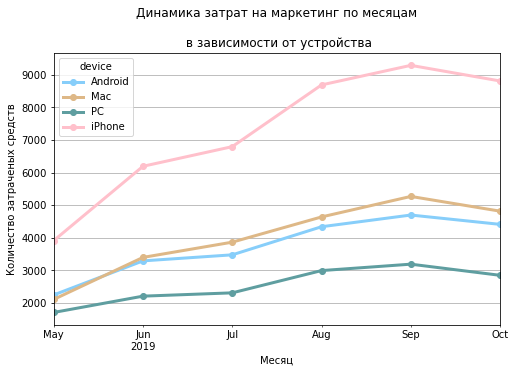

In [17]:
# динамика изменения затрат на маркетинг по месяцам
# в зависимости от устройства
(profiles.pivot_table(index=['device'],
                      columns='month',
                      values='acquisition_cost',
                      aggfunc='sum')
         .T.plot(grid=True,
                title='''Динамика затрат на маркетинг по месяцам
                \n в зависимости от устройства''',
                xlabel='Месяц',
                ylabel='Количество затраченых средств',
                figsize=(8, 5),
                color=['#87CEFA', '#DEB887', '#5F9EA0', '#FFC0CB'],
                linewidth=3, marker='o')
)
plt.show()

## Стоимость привлечения клиентов

In [40]:
# получим таблицу стоимости привлечения одного клиента 
# в зависимости от канала привлечения
test = (profiles.groupby('channel').agg({
    'user_id' : 'nunique',
    'acquisition_cost' : 'sum'
        })
    .reset_index()
    .sort_values(by='user_id', ascending=False)
       )
print('Общие затраты на маркетинг по каналам')
display(test)

Общие затраты на маркетинг по каналам


,channel,user_id,acquisition_cost
10,organic,56439,0.00
1,FaceBoom,29144,32445.60
6,TipTop,19561,54751.30
4,OppleCreativeMedia,8605,2151.25
2,LeapBob,8553,1797.60
7,WahooNetBanner,8553,5151.00
5,RocketSuperAds,4448,1833.00
3,MediaTornado,4364,954.48
8,YRabbit,4312,944.22
0,AdNonSense,3880,3911.25


In [19]:
import copy
cac_table = copy.copy(test)
cac_table['cac'] = cac_table['acquisition_cost'].div(cac_table['user_id'], axis=0)

del cac_table['user_id']
del cac_table['acquisition_cost']
cac_table = cac_table.query('channel != "organic"').sort_values(by='cac', ascending=False)
print('Таблица расчета затрат на привлечения одного человека "CAC"')
display(cac_table)

Таблица расчета затрат на привлечения одного человека "CAC"


,channel,cac
6,TipTop,2.799003
1,FaceBoom,1.113286
0,AdNonSense,1.008054
9,lambdaMediaAds,0.724802
7,WahooNetBanner,0.602245
5,RocketSuperAds,0.412095
4,OppleCreativeMedia,0.250000
8,YRabbit,0.218975
3,MediaTornado,0.218717
2,LeapBob,0.210172


In [20]:
# стоимость одного клиента в среднем
print('Стоимость привлечения одного клиента, за весь проект')
print(round(test['acquisition_cost'].sum()/test['user_id'].sum(), 2))

Стоимость привлечения одного клиента, за весь проект
0.7


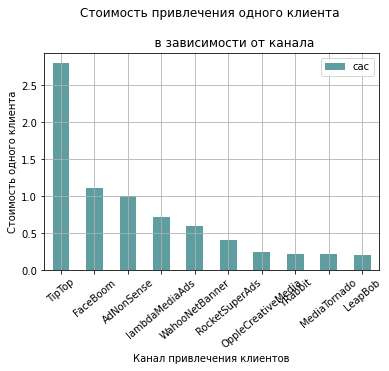

In [21]:
ax = (cac_table
    .plot(kind='bar', color='#5F9EA0', grid=True)
)
ax.set_xticks(range(10))
ax.set_xticklabels(cac_table['channel'].unique(), rotation=40)
plt.xlabel('Канал привлечения клиентов')
plt.ylabel('Стоимость одного клиента')
plt.title('''Стоимость привлечения одного клиента \n
            в зависимости от канала''')
plt.show()

## Выводы Блок 3

* Затраты на маркетинг растут со временем, самые большие траты приходятся на устройства Iphone
* В среднем стоимость привлечения одного клиента равна 0.7
* Самые высокие траты на рекламу приходятся на канал TipTop - затраты здесь, в среднем, в 2 и больше раз выше чем для остальных источников.

В дальнейшем, при рассмотрении мы исключим данные об "органических" пользователях, поскольку стоимость их привлечения равна 0, но они будут влиять на другие метрики, так как их когрта довольно большая.

# Оценка окупаемости рекламы

## Сглаживание метрик

In [22]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

## Визуализация LTV & ROI

In [23]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1,
              color=['#87CEFA', '#DEB887', '#5F9EA0', '#FFC0CB', '#483D8B', '#B22222', '#FFD700',
                    '#00BFFF', '#006400', '#800080'],
               linewidth=2)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2,
                                            color=['#87CEFA', '#DEB887', '#5F9EA0',
                                                   '#FFC0CB', '#483D8B', '#B22222', '#FFD700',
                                                    '#00BFFF', '#006400', '#800080'],
                                            linewidth=2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3,
                                            color=['#87CEFA', '#DEB887', '#5F9EA0',
                                                   '#FFC0CB', '#483D8B', '#B22222', '#FFD700',
                                                    '#00BFFF', '#006400', '#800080'],
                                            linewidth=2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4,
               color=['#87CEFA', '#DEB887', '#5F9EA0', '#FFC0CB', '#483D8B', '#B22222', '#FFD700',
                                                    '#00BFFF', '#006400', '#800080'],
               linewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5,
                                            color=['#87CEFA', '#DEB887', '#5F9EA0',
                                                   '#FFC0CB', '#483D8B', '#B22222', '#FFD700',
                                                    '#00BFFF', '#006400', '#800080'],
                                            linewidth=2)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

### Общая окупаемость рекламы

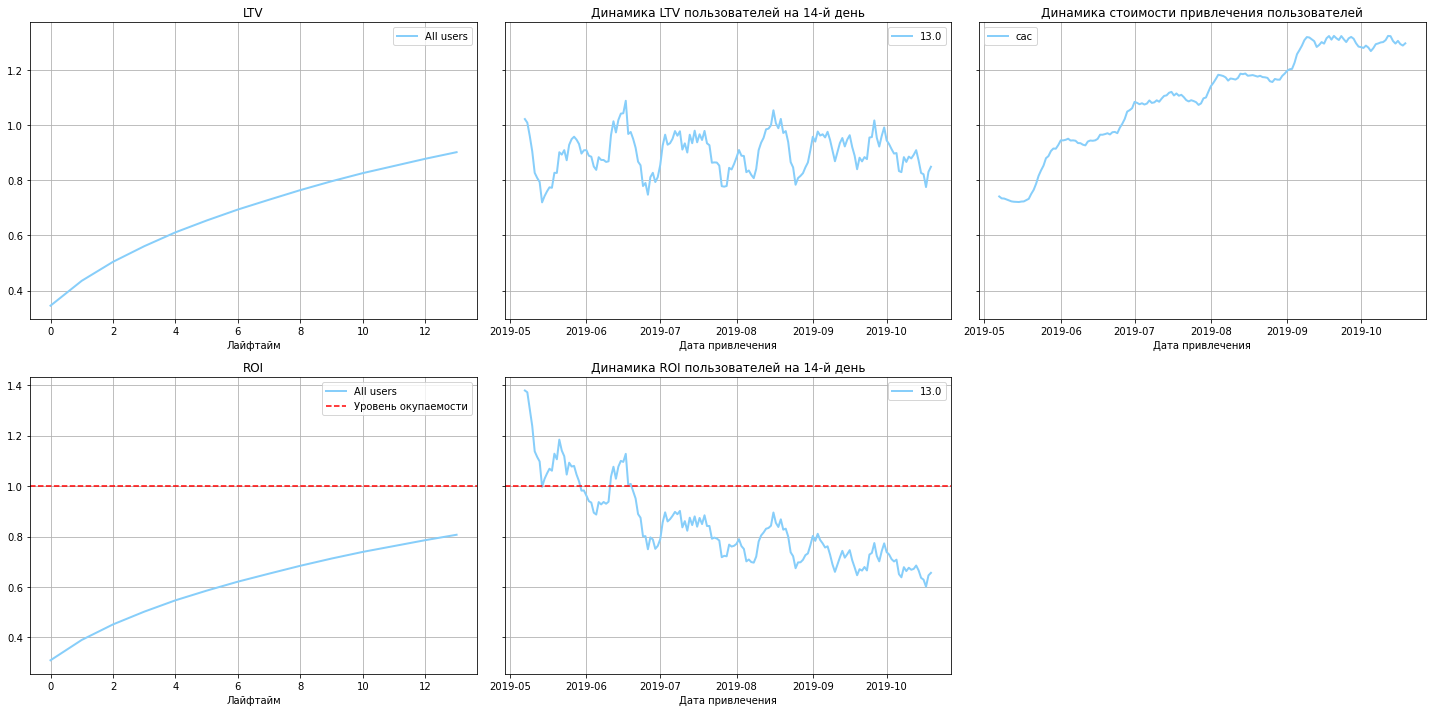

In [25]:
profiles1 = profiles.query('channel != "organic"')
ltv_raw, ltv_grouped,ltv_history, roi_grouped, roi_history = get_ltv(
profiles1, orders, observation_date, horizon_days) 

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

<div class="alert alert-success">
  
  <b>Комментарий ревьюера</b>
    
  ✔️ Тут верно убираешь из расчетов  пользователей с органическим трафиком, ведь мы за них ничего не платим.
</div>

**ВЫВОДЫ**

* LTV стабильно растет, и несмотря на сезонность, в целом стабильна.
* САС новых клиентов увеличивается, следовательно расходы на рекламу увеличиваются
* Реклама стабильно не окупается, если рассматривать окупаемость в динамике, то клиенты, привлеченные позже середины июня стабильно не окупаются.

Следует рассмотреть эти показатели с разбивкой по устройствам, которые используют пользователи, каналам привлечения и регионам.

### Окупаемость рекламы в разбивке по каналам привлечения

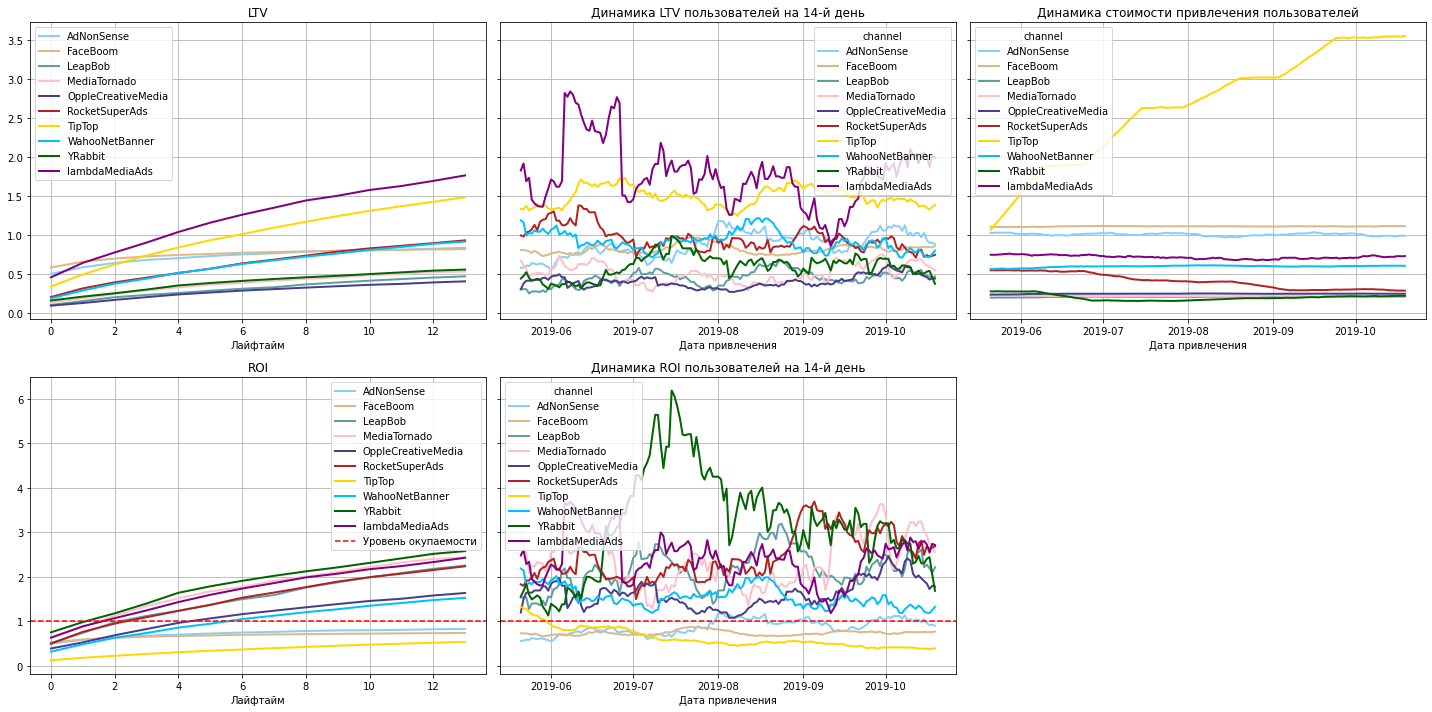

In [26]:
dimensions = ['channel']
ltv_raw, ltv_grouped,ltv_history, roi_grouped, roi_history = get_ltv(
profiles1, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

**ВЫВОДЫ**

1) Реклама не окупается для каналов:

    * AdNonSense
    * FaceBoom
    * TipTop
    
2) Затраты окупаются на 5 день для:

    * OppleCreativeMedia
    * WahooNetBanner
    
3) Затраты окупаются уже на 3 день:

    * LeapBob
    * MediaTornado
    * RocketSuperAds
    * YRabbit
    * lambdaMediaAds
    
4) CAC стабилен для всех платформ, кроме канала **TipTop**. Ометим это и будем иметь в виду - затраты увеличиваются в этом канале.

5) LTV достаточно стабилен


### Окупаемость рекламы в разбивке по регионам

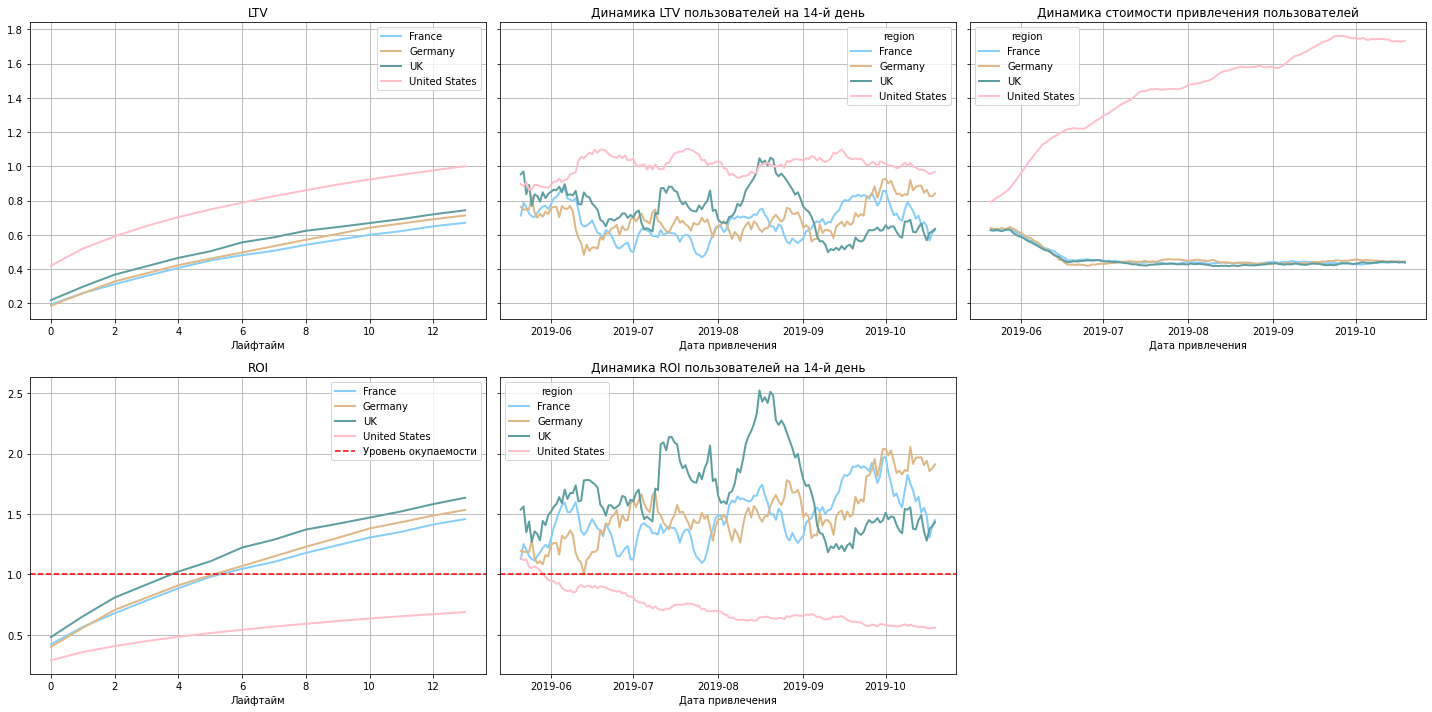

In [27]:
dimensions = ['region']
ltv_raw, ltv_grouped,ltv_history, roi_grouped, roi_history = get_ltv(
profiles1, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

**ВЫВОДЫ**

* САС для пользователей из США значительно растет, в то время как для пользователей других регионов снижается и далее остается неизменным.
* При том что стоимость привлечения пользователей в США растет это единственный регион. который к концу 14 дней не окупается, более того, если рассматривать динамику, то практически сразу ROI начинает снижаться и имеет отрицательную динамику.

### Окупаемость рекламы в разбивке по устройствам

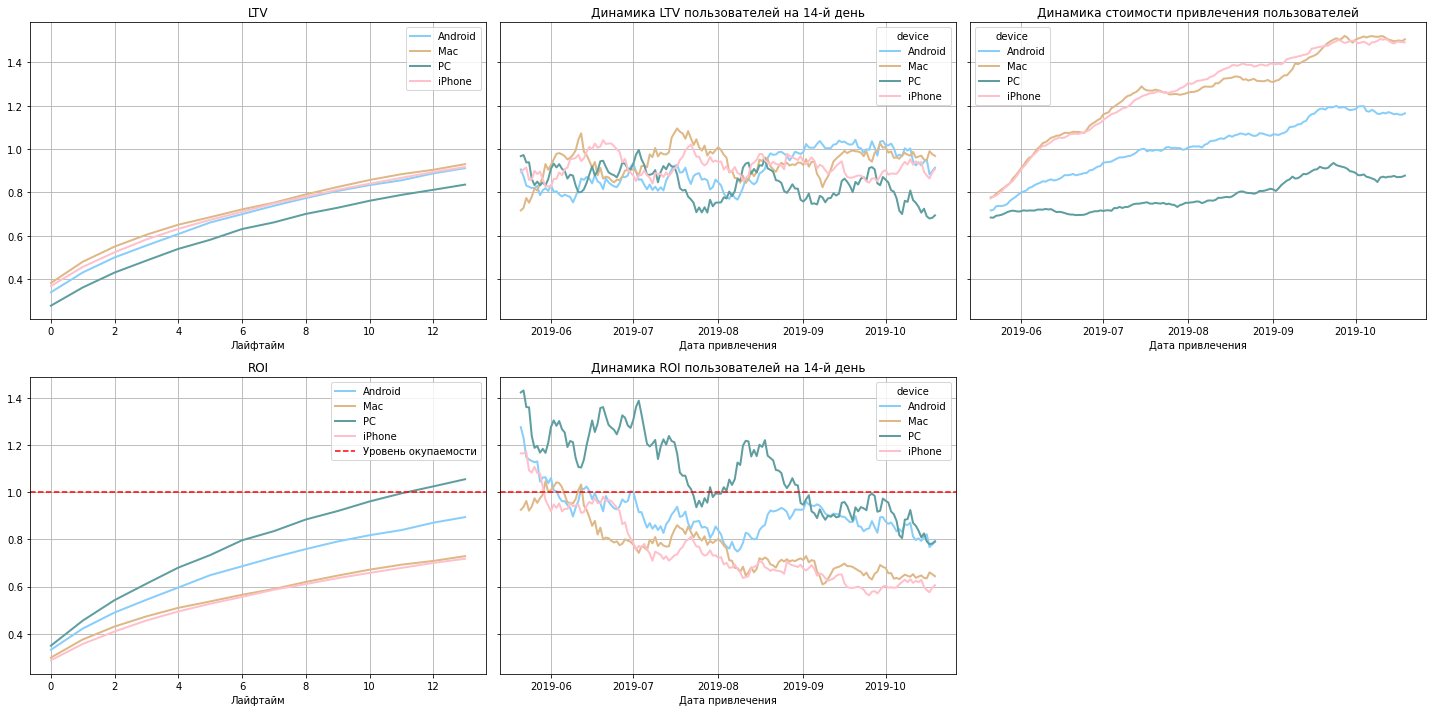

In [28]:
dimensions = ['device']
ltv_raw, ltv_grouped,ltv_history, roi_grouped, roi_history = get_ltv(
profiles1, orders, observation_date, horizon_days, dimensions=dimensions) 

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=21)

**ВЫВОДЫ**

* LTV стабилен в целом для всех типов устройств
* САС растет с наибольшей интенсивностью для IPhone и Мас, меньше всего для РС
* Из всех устройств лишь РС окупается к 11 дню, остальные - нет
* Если рассматривать динамику окупаемости - она имеет незначительные флуктуации, но общий тренд идет на убывание, причем из всех устройство только пользователи РС окупались до сентября 2019, для остальных устройств - неокупаемость налюдается практически сразу.

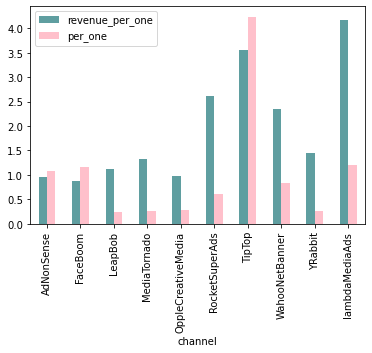

In [29]:
# как соотносятся затраты на одного клиента и прибыль
test_revenue = (profiles
                .query('channel != "organic"')
                .merge(orders[['user_id', 'revenue']], on='user_id', how='left')
               )
t1 = test_revenue.groupby('channel').agg({
    'user_id' : 'nunique',
    'revenue' : 'sum',
    'acquisition_cost' : 'sum'
})
t1['revenue_per_one'] = t1['revenue'].div(t1['user_id'], axis=0)
t1['per_one'] = t1['acquisition_cost'].div(t1['user_id'], axis=0)
t1

del t1['user_id']
del t1['revenue']
del t1['acquisition_cost']

t1.plot(kind='bar', color=['#5F9EA0', '#FFC0CB'])
plt.show()

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

Среди каналов привлечения есть те, которые к концу 14го дня не окупаются. Затраты на рекламные компании стабильны для всех каналов, кроме TipTop, затраты по нему увеличиваются, при этом до окупаемости далеко. Анализ зависимостей с разбивкой по регионам показал, что происходит увеличение затрат на рекламу в США, причем характер зависимости схож с тем что мы получили для канала TipTop. Можно предположить, что увеличение затрат на рекламную компанию канала TipTop в регионе США приводит к ухудшению общего показателя окупаемости.

Следует разобраться в чем причина неокупаемости рекламных компаний в США - возможно привлеченные пользователи "отваливаются" или плохо конвертируются.

## Визуализация конверсии

In [30]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Конверсия с разбивкой по каналам привлечения

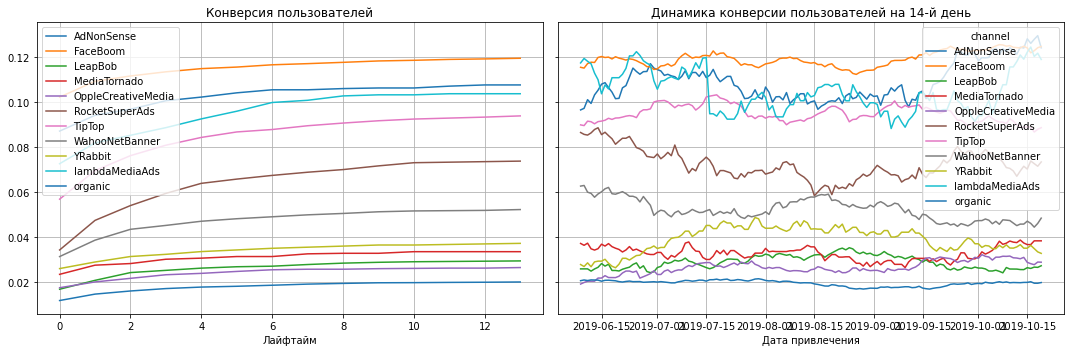

In [31]:
conversion_raw, conversion, conversion_dynamics = get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=['channel'])
plot_conversion(conversion, conversion_dynamics, horizon_days, window=40)

**ВЫВОД**
* Конверсионные кривые имеют положительную динамику, однако крайне низкую. Для ряда каналов привлечения конверсия к 14му дню едва достигает 4%. 
* Лучше всего конвертируются пользователи из канала FaceBoom, однако конверсия к концу второй недели не превышает 12%.

### Конверсия с разбивкой по регионам

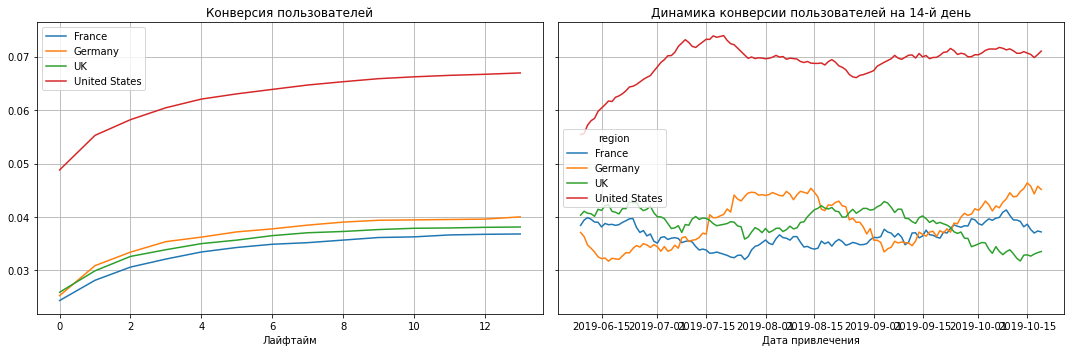

In [32]:
conversion_raw, conversion, conversion_dynamics = get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=['region'])
plot_conversion(conversion, conversion_dynamics, horizon_days, window=40)

**ВЫВОД**

* пользователи США конвертируются лучше всего, к концу 14го дня конверсия достигает 10%. Анализ динамики конверсии также указывает на то что пользователи из США, привлеченные в разное время, конвертируются на 14 день в 2 раза лучше чем пользователи других регионов.
* конверсия пользователей других регионов на 14 день не превышает 5%

Анализ показателей LTV по регионам показал что именно пользователи из США не окупаются к 14 дню, в то время как остальные регионы - переходят черту окупаемости. При этом конверсия для пользователей США растет, значит дело не в конверсии.

### Конверсия с разбивкой по устройствам

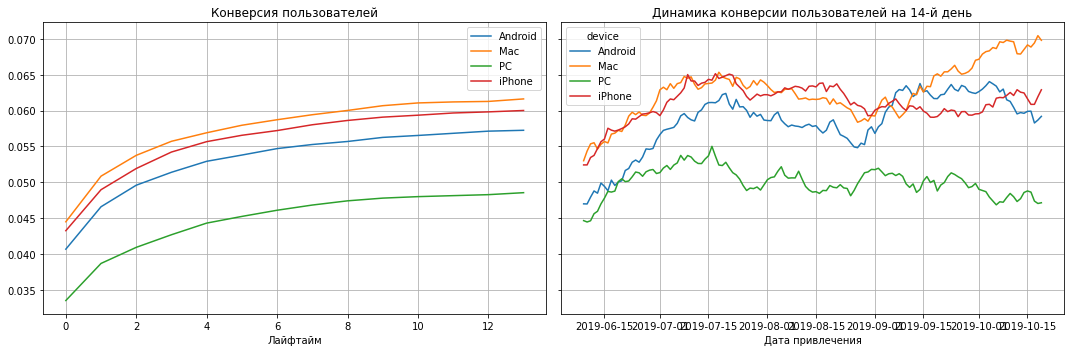

In [33]:
conversion_raw, conversion, conversion_dynamics = get_conversion(
        profiles, orders, observation_date, horizon_days, dimensions=['device'])
plot_conversion(conversion, conversion_dynamics, horizon_days, window=40)

**ВЫВОД**

* хуже всего конвертируются пользователи использующие РС для приложения

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

Анализ данных зависимостей конверсии пользователей в зависимости от канала привлечения, региона и используемого девайса показал, что, несмотря на то, что для США характерно увеличение затрат на рекламу и недостижение окупаемости, пользователи этого региона конвертируются лучше остальных.

То же верно и для 3х каналов привлечения, ROI данных каналов показывает что затраты на привлечение клиентов не окупаются, в то время как конверсия для этих каналов наивысшая.

Таким образом проблема, все же, не в конверсии, и стоит рассмотреть кривые удержания, чтобы ответить на вопрос - почему реклама не окупается.

## Визуализация удержания

In [34]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

### Удержание с разбивкой по регионам

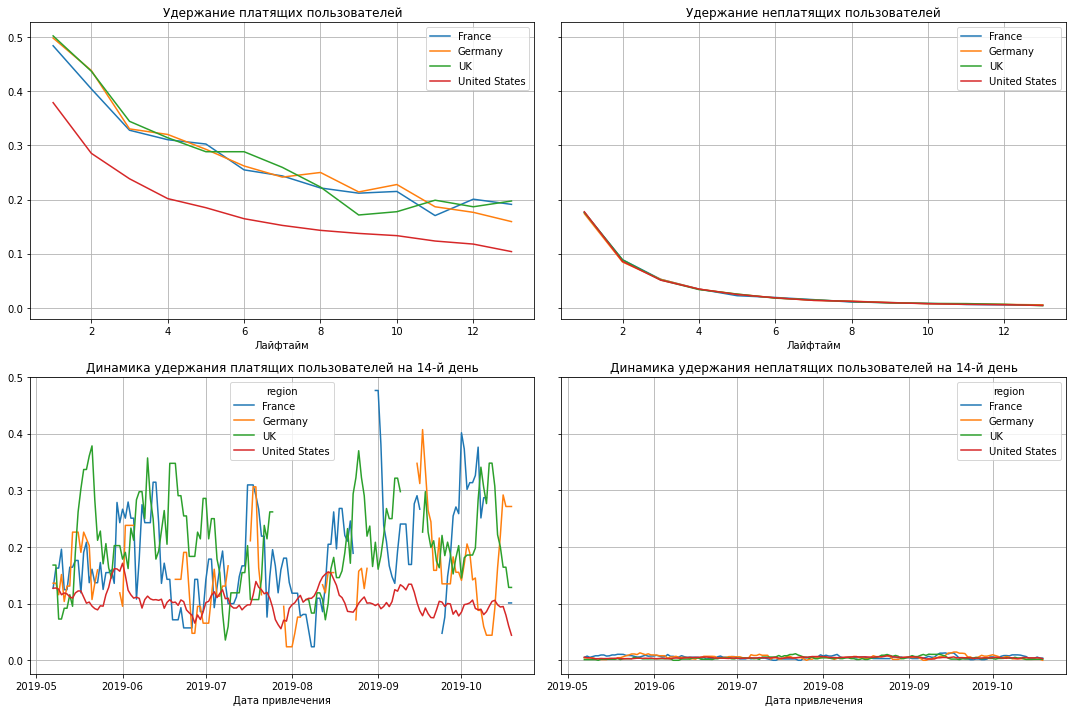

In [35]:
retention_raw, retention_result, retention_dynamics = get_retention(
        profiles,
        visits,
        observation_date,
        horizon_days,
        dimensions=['region'])
plot_retention(retention_result, retention_dynamics, horizon_days, window=7) 

**ВЫВОД**

Анализ графиков показал что
* платящие пользователи из США  удерживаются значительно хуже остальных.
* платящие пользователи, в целом, удерживаются лучше неплатящих.

### Удержание с разбивкой по каналам привлечения

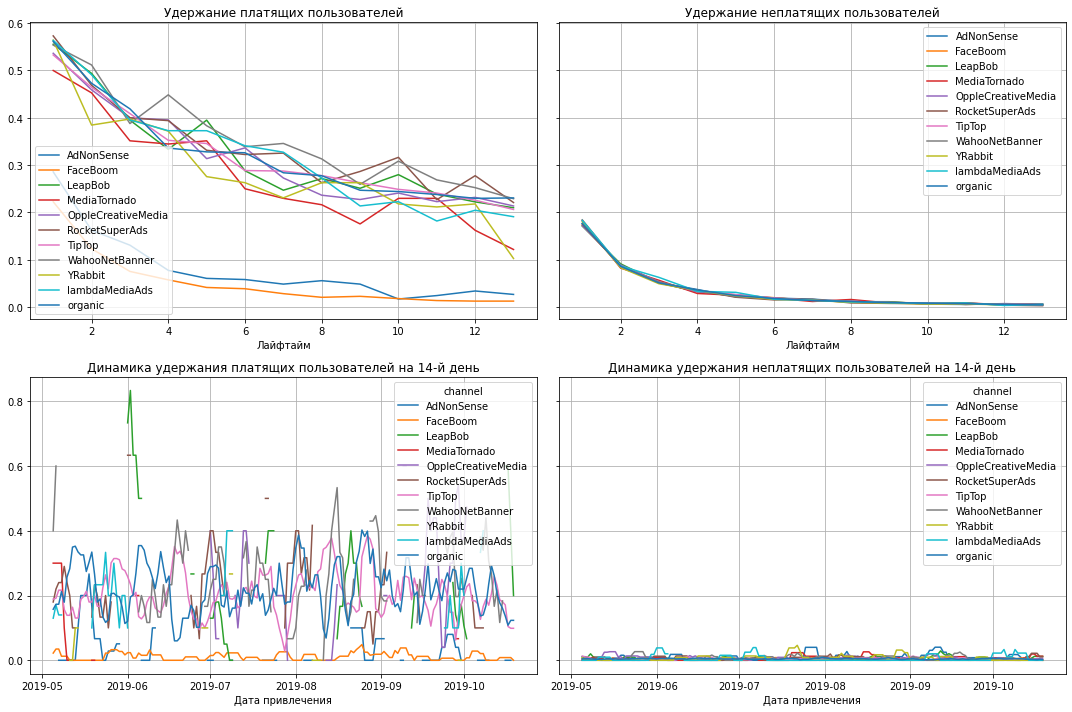

In [36]:
retention_raw, retention_result, retention_dynamics = get_retention(
        profiles,
        visits,
        observation_date,
        horizon_days,
        dimensions=['channel'])
plot_retention(retention_result, retention_dynamics, horizon_days, window=5) 

**ВЫВОД**

Анализ графиков показал что в среднем платящие пользователи удерживаются лучше чем неплатящие. Однако два канала - AdNonSense и FaceBoom удерживаются хуже остальных каналов.

### Удержание с разбивкой по устройствам

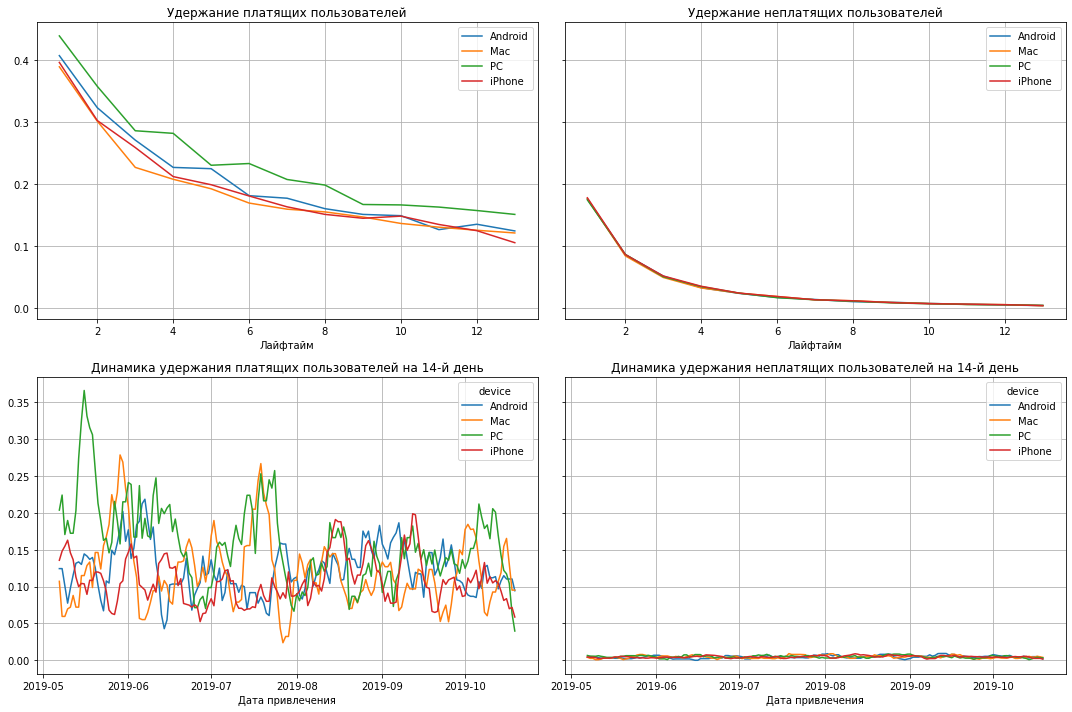

In [37]:
retention_raw, retention_result, retention_dynamics = get_retention(
        profiles,
        visits,
        observation_date,
        horizon_days,
        dimensions=['device'])
plot_retention(retention_result, retention_dynamics, horizon_days, window=7)

**ВЫВОД**
Анализ графиков показал что: платящие пользователи удерживаются , в целом, лучше неплатящих

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

Как и ожидалось мы видим что кривые удержания для пользователей из США значительно ниже остальных регионов, то же справедливо и для кривых удержания каналов привлечения - у AdNonSence & FaceBoom показатели удержания платящих пользователей схожи с показателями удержания неплатящих пользователей.

**ВОПРОС 1: окупается ли в целом реклама**

Для ответа на вопрос **окупается ли в целом реклама** сформируем таблицу где сгруппируем затраты и выручку на каждого клиента, и вычтем из суммы выручки - сумму затрат. Если результат будет положительным - ответ будет положительным.

In [38]:
q1 = test_revenue.groupby(['user_id']).agg({'acquisition_cost':'sum', 'revenue':'sum'})
result = q1['revenue'].sum() - q1['acquisition_cost'].sum() 
if result > 0:
    print('В целом реклама окупается, профицит: + {}'.format(result))
else:
    print('Реклама не окупается, дефицит: - {}'.format(result))

В целом реклама окупается, профицит: + 29219.3347402926


**ВОПРОС 2: Какие устройства, страны и каналы могут снижать окупаемость рекламы?**

* Среди регионов стоит выделить США. Поскольку из-за низкого удержания и все возрастающих затрат на рекламу, пользователи из этого региона не окупаются.
* Среди каналов не окупаются три - 
    * AdNonSense
    * FaceBoom
    * TipTop
* Среди устройств - МАС, Iphone & Android не окупаются на 14 день

**ВОПРОС 3: Чем могут быть вызваны проблемы окупаемости?**

Проблемы окупаемости могут возникать вследствии увеличения вложений в рекламные компании и малого процента удержания клиентов.

In [49]:
# проверка по кол-ву пользователей через разные каналы по регионам
(profiles.groupby(['region', 'channel']).agg({'user_id':'nunique'}))

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
              organic                6392
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
              organic                5453
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
              organic                6421
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312
              organic               38173

# Финальный вывод

* Неэффективность рекламных компаний может быть связана с тем, что в некоторые каналы (TipTop) вкладывается довольно много средств, в то время как удержание пользователей находится на довольно низком уровне.
* Низкие показатели удержания в разбивке по каналам привлечения могут быть связаны с тем что в данных каналах предлагаются (указываются) не те вещи , которые пользователь получает в итоге. Таким образом - показатель удержания стремительно снижается.
* Низкие показатели удержания для всех устройств может быть связана с неудобством использования приложения для пользователей.  

**РЕКОММЕНДАЦИИ ДЛЯ ОТДЕЛА МАРКЕТИНГА**

* Увеличить показатели удержания клиентов. Особое внимание уделить пользователям из США, поскольку у них самые низкие показатели удержания. В целом стремиться к увеличению данного показателя для всех регионов.
* Удержание клиентов в зависимости от используемого устройства довольно низкое. К 14 дню для платящих клиентов снижается до 10%. Следует рассмотреть возможные варианты: нанять юзабилити экспертов, протестировать приложение, возможно дизайн или удобство приложения низкое, следовательно - не удобное для пользователей
* Уделить внимание 3м каналам, которые неокупаются: AdNonSense, FaceBoom (TipTop) необходимо увеличить показатель удержания. Особое внимание уделить первым двум - для них показатели удержания платящих пользователей близка к показателям неплатящих пользователей.
* ОТдельно еще раз стоит отметить FaceBoom канал, поскольку на его долю приходится самое большое число привлеченных клиентов США, при этом именно в этом канале самая большая доля платящих, так что увеличение показателя удержания может сильно улучшить ситуацию.
* В целом необходимо создать дополнительную ценность для каждого клиента, возможно, доавить более персонализированное общение с пользователями, система поощрений за покупки, бонусы и акции - все это может повысить как конверсию, так и показатель удержания клиентов.

* Стоит принять шаги для увеличения конверсии в целом.

* Стоит отметить каналы привлечения пользователей, в которых окупаемость достигается уже на 3 день. Возможно для этих каналов можно увеличить рекламных компаний, чтобы привлечь дополнительных клиентов.
    * LeapBob
    * MediaTornado
    * RocketSuperAds
    * YRabbit
    * lambdaMediaAds
* Для оптимизации затрат на рекламу в регионе США, следует обратить внимание на каналы, удержание которых на более хорошем уровне, например - YRabbit, MediaTornado, RocketSuperAds. Следует увеличить рекламный бюджет и привлечь больше клиентов, и, таким образом, оптимизировать затраты на весь регион США в целом.
* Для пользователей других регионов (Германия, Франция и Великобритания) стоит обратить внимание на каналы привлечения LeapBob и lambdaMediaAds. Следует увеличить количество привлеченных пользователей через эти каналы. 